<a href="https://colab.research.google.com/github/yevonnaelandrew/galaxy-classification-ensemble/blob/main/All_Color_Space_ResNet50_Non_trainable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
import glob
import pandas as pd

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/galaxy-images/img_RGB.zip /content/img_RGB.zip

In [ ]:
!unzip /content/img_RGB.zip

Streaming output truncated to the last 5000 lines.
  inflating: content/img_RGB/spiral/598869.jpg  
  inflating: content/img_RGB/spiral/111799.jpg  
  inflating: content/img_RGB/spiral/780317.jpg  
  inflating: content/img_RGB/spiral/910544.jpg  
  inflating: content/img_RGB/spiral/834411.jpg  
  inflating: content/img_RGB/spiral/733208.jpg  
  inflating: content/img_RGB/spiral/886610.jpg  
  inflating: content/img_RGB/spiral/911110.jpg  
  inflating: content/img_RGB/spiral/708993.jpg  
  inflating: content/img_RGB/spiral/412282.jpg  
  inflating: content/img_RGB/spiral/329964.jpg  
  inflating: content/img_RGB/spiral/550580.jpg  
  inflating: content/img_RGB/spiral/481037.jpg  
  inflating: content/img_RGB/spiral/981685.jpg  
  inflating: content/img_RGB/spiral/213331.jpg  
  inflating: content/img_RGB/spiral/545684.jpg  
  inflating: content/img_RGB/spiral/979242.jpg  
  inflating: content/img_RGB/spiral/791017.jpg  
  inflating: content/img_RGB/spiral/797954.jpg  
  inflating: conte

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
!pip install tensorflow-io
import tensorflow_io as tfio

     |████████████████████████████████| 23.4 MB 1.2 MB/s 


In [63]:
def train_model(convert_color, original=False, preprocess=False):
  data_dir = pathlib.Path('/content/content/img_RGB')

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  if original == True:
    print("Using the original RGB and preprocessing")
    x = tf.keras.applications.resnet50.preprocess_input(x)
  elif original == False:
    x = tf.keras.layers.Rescaling(scale=1./255)(x)
    x = convert_color(x)
    print("Using the converted colors")

  if preprocess == True:
    x = tf.keras.applications.resnet50.preprocess_input(x)
    print("Using preprocessing")

  x = base_model(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  outputs = tf.keras.layers.Dense(5)(x)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0001

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=50
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the original RGB and preprocessing
Epoch 1/50
360/360 [==============================] - 42s 91ms/step - loss: 0.7002 - accuracy: 0.7193 - val_loss: 0.4847 - val_accuracy: 0.7998
Epoch 2/50
360/360 [==============================] - 32s 88ms/step - loss: 0.5223 - accuracy: 0.7774 - val_loss: 0.4532 - val_accuracy: 0.8091
Epoch 3/50
360/360 [==============================] - 32s 89ms/step - loss: 0.4818 - accuracy: 0.7972 - val_loss: 0.4262 - val_accuracy: 0.8220
Epoch 4/50
360/360 [==============================] - 32s 89ms/step - loss: 0.4561 - accuracy: 0.8063 - val_loss: 0.4093 - val_accuracy: 0.8286
Epoch 5/50
360/360 [==============================] - 32s 89ms/step - loss: 0.4401 - accuracy: 0.8142 - val_loss: 0.4421 - val_accuracy: 0.8107
Epoch 6/50
360/360 [==============================] - 32s 90ms/step - loss: 0.4353 - accur

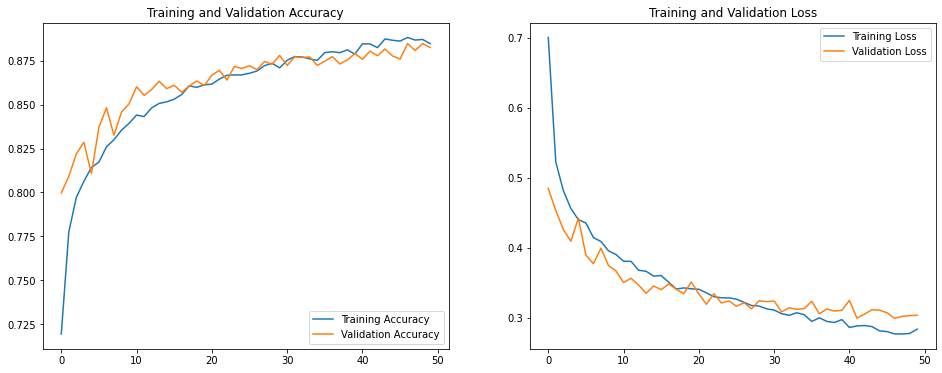

In [47]:
train_model(None, original=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/50
360/360 [==============================] - 45s 96ms/step - loss: 0.7389 - accuracy: 0.6939 - val_loss: 0.5463 - val_accuracy: 0.7659
Epoch 2/50
360/360 [==============================] - 34s 93ms/step - loss: 0.5990 - accuracy: 0.7452 - val_loss: 0.5039 - val_accuracy: 0.7926
Epoch 3/50
360/360 [==============================] - 34s 94ms/step - loss: 0.5559 - accuracy: 0.7637 - val_loss: 0.5062 - val_accuracy: 0.7787
Epoch 4/50
360/360 [==============================] - 34s 95ms/step - loss: 0.5301 - accuracy: 0.7744 - val_loss: 0.5211 - val_accuracy: 0.7787
Epoch 5/50
360/360 [==============================] - 34s 95ms/step - loss: 0.5180 - accuracy: 0.7809 - val_loss: 0.4655 - val_accuracy: 0.8029
Epoch 6/50
360/360 [==============================] - 34s 95ms/step - loss: 0.5012 -

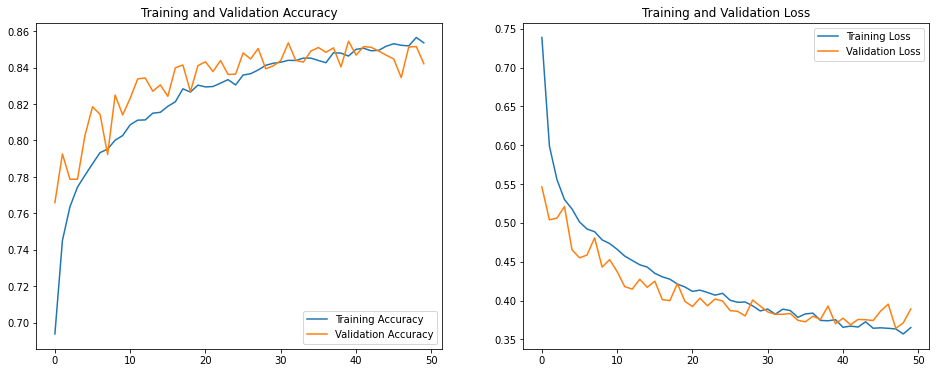

In [ ]:
train_model(tfio.experimental.color.rgb_to_lab, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/50
360/360 [==============================] - 45s 97ms/step - loss: 0.8748 - accuracy: 0.6467 - val_loss: 0.6048 - val_accuracy: 0.7345
Epoch 2/50
360/360 [==============================] - 34s 94ms/step - loss: 0.6674 - accuracy: 0.7161 - val_loss: 0.5692 - val_accuracy: 0.7577
Epoch 3/50
360/360 [==============================] - 34s 95ms/step - loss: 0.6312 - accuracy: 0.7349 - val_loss: 0.5758 - val_accuracy: 0.7487
Epoch 4/50
360/360 [==============================] - 34s 95ms/step - loss: 0.6009 - accuracy: 0.7478 - val_loss: 0.5294 - val_accuracy: 0.7765
Epoch 5/50
360/360 [==============================] - 34s 95ms/step - loss: 0.5846 - accuracy: 0.7564 - val_loss: 0.5125 - val_accuracy: 0.7853
Epoch 6/50
360/360 [==============================] - 34s 95ms/step - loss: 0.5644 - accuracy: 0.7604 - 

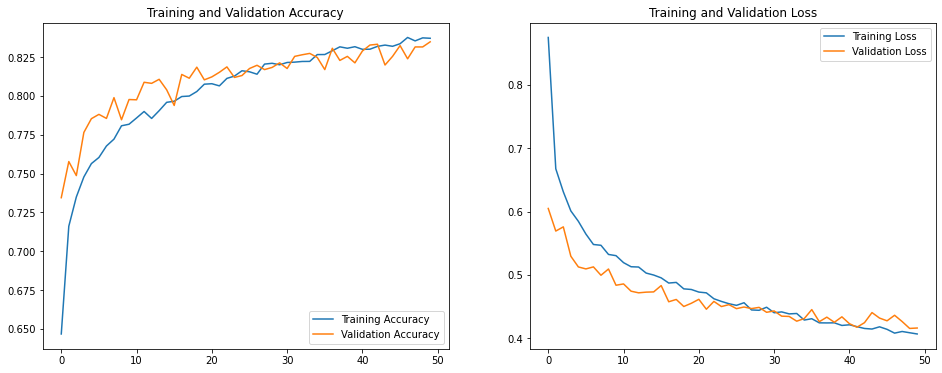

In [ ]:
train_model(tfio.experimental.color.rgb_to_lab, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/50
360/360 [==============================] - 43s 93ms/step - loss: 1.4712 - accuracy: 0.2836 - val_loss: 1.4152 - val_accuracy: 0.4027
Epoch 2/50
360/360 [==============================] - 32s 90ms/step - loss: 1.4347 - accuracy: 0.2911 - val_loss: 1.4096 - val_accuracy: 0.2890
Epoch 3/50
360/360 [==============================] - 33s 91ms/step - loss: 1.4289 - accuracy: 0.2917 - val_loss: 1.4108 - val_accuracy: 0.2862
Epoch 4/50
360/360 [==============================] - 33s 91ms/step - loss: 1.4271 - accuracy: 0.2930 - val_loss: 1.4159 - val_accuracy: 0.2860
Epoch 5/50
360/360 [==============================] - 33s 92ms/step - loss: 1.4263 - accuracy: 0.2903 - val_loss: 1.4122 - val_accuracy: 0.4055
Epoch 6/50
360/360 [==============================] - 33s 92ms/step - loss: 1.4236 -

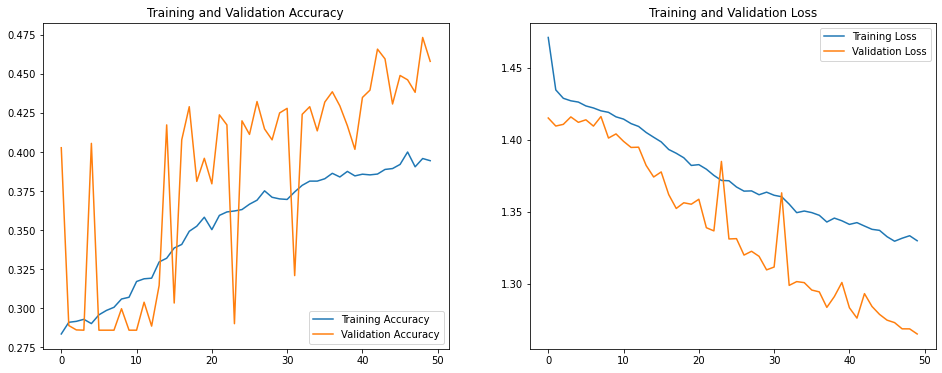

In [ ]:
train_model(tfio.experimental.color.rgb_to_xyz, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/50
360/360 [==============================] - 44s 95ms/step - loss: 1.4521 - accuracy: 0.2845 - val_loss: 1.4218 - val_accuracy: 0.2746
Epoch 2/50
360/360 [==============================] - 32s 90ms/step - loss: 1.4297 - accuracy: 0.2951 - val_loss: 1.4141 - val_accuracy: 0.2860
Epoch 3/50
360/360 [==============================] - 33s 91ms/step - loss: 1.4245 - accuracy: 0.3005 - val_loss: 1.4150 - val_accuracy: 0.2860
Epoch 4/50
360/360 [==============================] - 33s 91ms/step - loss: 1.4207 - accuracy: 0.3057 - val_loss: 1.4043 - val_accuracy: 0.2867
Epoch 5/50
360/360 [==============================] - 33s 92ms/step - loss: 1.4181 - accuracy: 0.3081 - val_loss: 1.4008 - val_accuracy: 0.2864
Epoch 6/50
360/360 [==============================] - 33s 92ms/step - loss: 1.4134 - accuracy: 0.3171 - 

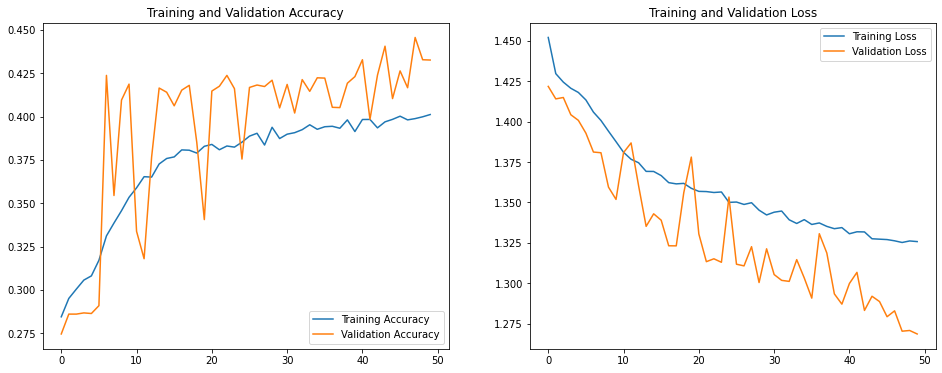

In [ ]:
train_model(tfio.experimental.color.rgb_to_xyz, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/50
360/360 [==============================] - 42s 90ms/step - loss: 1.4191 - accuracy: 0.3427 - val_loss: 1.2442 - val_accuracy: 0.4620
Epoch 2/50
360/360 [==============================] - 31s 87ms/step - loss: 1.2970 - accuracy: 0.4153 - val_loss: 1.2014 - val_accuracy: 0.4540
Epoch 3/50
360/360 [==============================] - 32s 88ms/step - loss: 1.2478 - accuracy: 0.4414 - val_loss: 1.1356 - val_accuracy: 0.5076
Epoch 4/50
360/360 [==============================] - 32s 89ms/step - loss: 1.2215 - accuracy: 0.4530 - val_loss: 1.1169 - val_accuracy: 0.5224
Epoch 5/50
360/360 [==============================] - 32s 89ms/step - loss: 1.2001 - accuracy: 0.4660 - val_loss: 1.1073 - val_accuracy: 0.5146
Epoch 6/50
360/360 [==============================] - 32s 90ms/step - loss: 1.1844 -

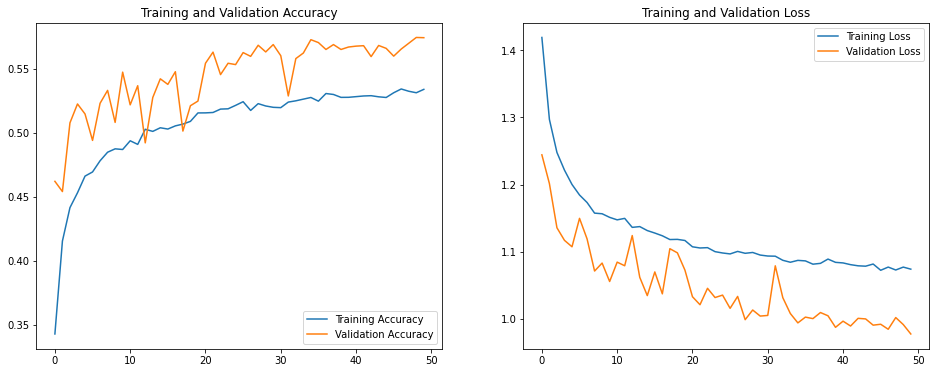

In [ ]:
train_model(tfio.experimental.color.rgb_to_hsv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/50
360/360 [==============================] - 43s 93ms/step - loss: 1.4061 - accuracy: 0.3328 - val_loss: 1.2703 - val_accuracy: 0.4364
Epoch 2/50
360/360 [==============================] - 32s 90ms/step - loss: 1.3152 - accuracy: 0.3941 - val_loss: 1.1803 - val_accuracy: 0.4757
Epoch 3/50
360/360 [==============================] - 33s 90ms/step - loss: 1.2508 - accuracy: 0.4349 - val_loss: 1.1754 - val_accuracy: 0.5038
Epoch 4/50
360/360 [==============================] - 33s 90ms/step - loss: 1.2174 - accuracy: 0.4561 - val_loss: 1.1401 - val_accuracy: 0.5045
Epoch 5/50
360/360 [==============================] - 33s 91ms/step - loss: 1.1992 - accuracy: 0.4676 - val_loss: 1.1293 - val_accuracy: 0.5082
Epoch 6/50
360/360 [==============================] - 33s 91ms/step - loss: 1.1828 - accuracy: 0.4784 - 

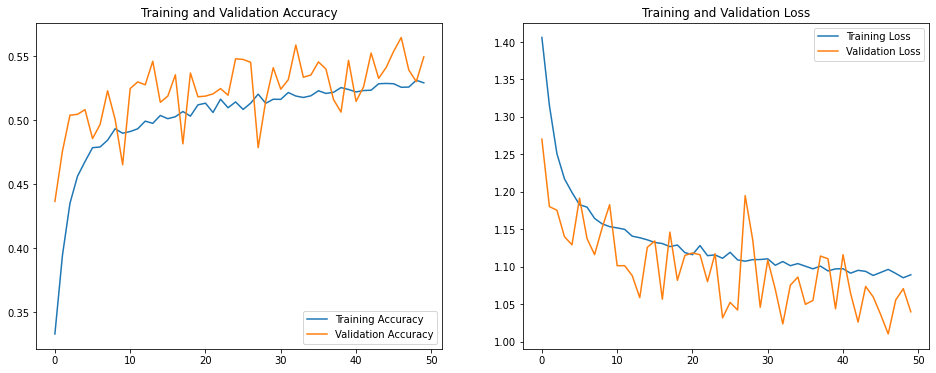

In [ ]:
train_model(tfio.experimental.color.rgb_to_hsv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/50
360/360 [==============================] - 44s 93ms/step - loss: 1.4746 - accuracy: 0.2792 - val_loss: 1.4149 - val_accuracy: 0.2860
Epoch 2/50
360/360 [==============================] - 33s 91ms/step - loss: 1.4351 - accuracy: 0.2885 - val_loss: 1.4221 - val_accuracy: 0.2860
Epoch 3/50
360/360 [==============================] - 33s 91ms/step - loss: 1.4318 - accuracy: 0.2876 - val_loss: 1.4154 - val_accuracy: 0.2890
Epoch 4/50
360/360 [==============================] - 33s 92ms/step - loss: 1.4285 - accuracy: 0.2889 - val_loss: 1.4157 - val_accuracy: 0.2860
Epoch 5/50
360/360 [==============================] - 33s 92ms/step - loss: 1.4271 - accuracy: 0.2882 - val_loss: 1.4208 - val_accuracy: 0.2746
Epoch 6/50
360/360 [==============================] - 33s 92ms/step - loss: 1.4278 -

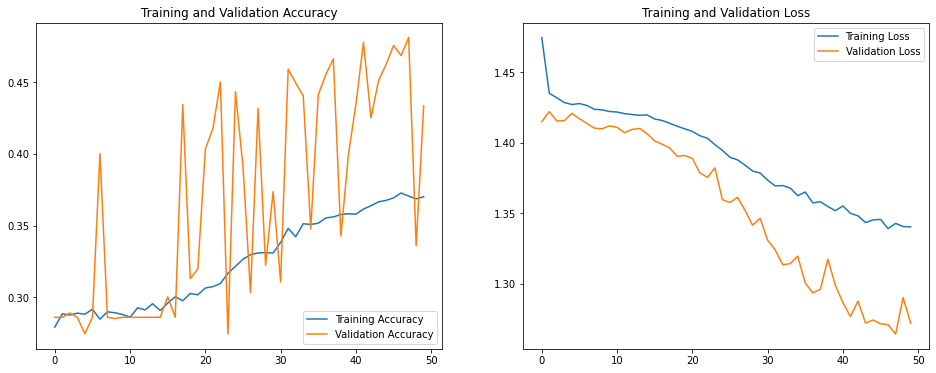

In [55]:
train_model(tfio.experimental.color.rgb_to_yuv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/50
360/360 [==============================] - 44s 95ms/step - loss: 1.4503 - accuracy: 0.2828 - val_loss: 1.4155 - val_accuracy: 0.2890
Epoch 2/50
360/360 [==============================] - 33s 92ms/step - loss: 1.4309 - accuracy: 0.2833 - val_loss: 1.4134 - val_accuracy: 0.3315
Epoch 3/50
360/360 [==============================] - 33s 92ms/step - loss: 1.4281 - accuracy: 0.2857 - val_loss: 1.4115 - val_accuracy: 0.2746
Epoch 4/50
360/360 [==============================] - 33s 92ms/step - loss: 1.4260 - accuracy: 0.2919 - val_loss: 1.4122 - val_accuracy: 0.2746
Epoch 5/50
360/360 [==============================] - 33s 92ms/step - loss: 1.4242 - accuracy: 0.2919 - val_loss: 1.4107 - val_accuracy: 0.2890
Epoch 6/50
360/360 [==============================] - 33s 92ms/step - loss: 1.4244 - accuracy: 0.2894 - 

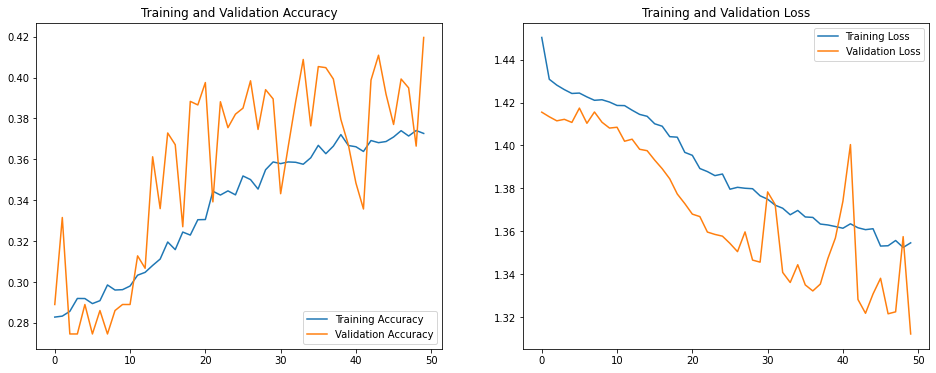

In [56]:
train_model(tfio.experimental.color.rgb_to_yuv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/50
360/360 [==============================] - 43s 93ms/step - loss: 1.4601 - accuracy: 0.2829 - val_loss: 1.4100 - val_accuracy: 0.2890
Epoch 2/50
360/360 [==============================] - 33s 91ms/step - loss: 1.4317 - accuracy: 0.2907 - val_loss: 1.4138 - val_accuracy: 0.2860
Epoch 3/50
360/360 [==============================] - 33s 91ms/step - loss: 1.4258 - accuracy: 0.2964 - val_loss: 1.4083 - val_accuracy: 0.2853
Epoch 4/50
360/360 [==============================] - 33s 91ms/step - loss: 1.4209 - accuracy: 0.3040 - val_loss: 1.3983 - val_accuracy: 0.3178
Epoch 5/50
360/360 [==============================] - 33s 92ms/step - loss: 1.4170 - accuracy: 0.3124 - val_loss: 1.3908 - val_accuracy: 0.3194
Epoch 6/50
360/360 [==============================] - 33s 92ms/step - loss: 1.4086 -

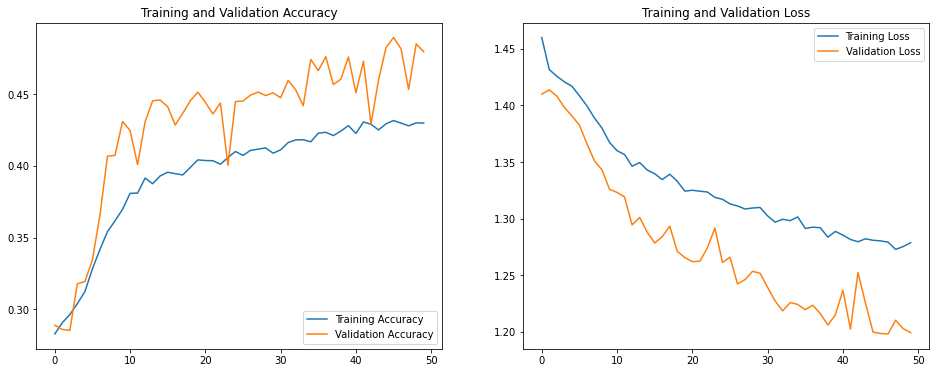

In [57]:
train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/50
360/360 [==============================] - 44s 95ms/step - loss: 1.4551 - accuracy: 0.2848 - val_loss: 1.4097 - val_accuracy: 0.3948
Epoch 2/50
360/360 [==============================] - 33s 92ms/step - loss: 1.4316 - accuracy: 0.2909 - val_loss: 1.4119 - val_accuracy: 0.2746
Epoch 3/50
360/360 [==============================] - 33s 92ms/step - loss: 1.4255 - accuracy: 0.2952 - val_loss: 1.4099 - val_accuracy: 0.2749
Epoch 4/50
360/360 [==============================] - 33s 92ms/step - loss: 1.4218 - accuracy: 0.2995 - val_loss: 1.4038 - val_accuracy: 0.3685
Epoch 5/50
360/360 [==============================] - 33s 92ms/step - loss: 1.4158 - accuracy: 0.3093 - val_loss: 1.3928 - val_accuracy: 0.2876
Epoch 6/50
360/360 [==============================] - 33s 92ms/step - loss: 1.4071 - accuracy: 0.3232 - 

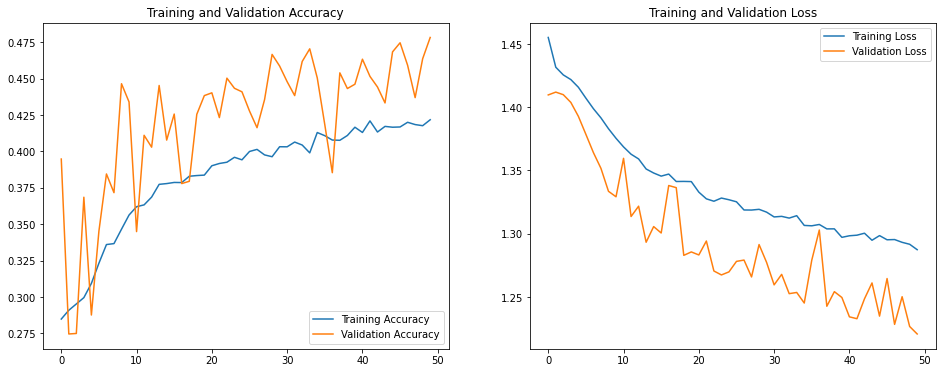

In [58]:
train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=False)